<a href="https://colab.research.google.com/github/claubermartins/Stock-market-prediction-FII/blob/master/Stock-market-prediction-FII-GTWR11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
pip install inflection

#**1-Importando bibliotecas**

In [57]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import seaborn as sns
import datetime
import inflection
from keras.models import load_model
from IPython.core.display import HTML

#**2-Funções auxiliares para o Jupyter Notebook**

In [58]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [59]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


##**2.1Método de importação de arquivos do Google Colab**

In [60]:
from google.colab import files
upload = files.upload()
print("downloaded files: ")
print(*upload, sep = "\n")

Saving GTWR11_treinamento.csv to GTWR11_treinamento.csv
downloaded files: 
GTWR11_treinamento.csv


#**3-Tratamento dos dados**

##**3.1-Importando os dados**

In [61]:
base = pd.read_csv('GTWR11_treinamento.csv')
base = base.drop('Date', axis = 1)

In [62]:
#valores estatísticos
base.describe()

,Open,High,Low,Close,Adj Close,Volume
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,103.241652,103.952275,102.186261,103.198812,102.278544,18436.008696
std,12.939010,12.845306,12.968533,12.949543,12.828383,18935.592403
min,69.089996,69.099998,68.099998,69.050003,68.432144,2843.000000
25%,99.150002,100.025000,97.774998,98.717497,97.834170,10038.250000
50%,106.135002,106.870003,105.224998,106.194999,105.244766,14849.000000
75%,112.687498,113.307499,111.507502,112.622497,111.614746,21164.000000
max,122.500000,122.800003,121.000000,122.800003,121.701187,345517.000000


In [63]:
base.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

##**3.2-Tratando os Valores Faltantes**

In [64]:
#valores faltantes
base.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [65]:
#encontrando onde os valores faltantes estão
base.loc[pd.isnull(base['Open'])]
base.loc[pd.isnull(base['High'])]
base.loc[pd.isnull(base['Low'])]
base.loc[pd.isnull(base['Close'])]
base.loc[pd.isnull(base['Adj Close'])]
base.loc[pd.isnull(base['Volume'])]

,Open,High,Low,Close,Adj Close,Volume
58,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=0)
imputer = imputer.fit(base.iloc[:,0:6])
base.iloc[:,0:6] = imputer.transform(base.iloc[:,0:6])

In [67]:
#verificando novamente se ainda temos valores faltantes
base.loc[pd.isnull(base['Open'])]
base.loc[pd.isnull(base['High'])]
base.loc[pd.isnull(base['Low'])]
base.loc[pd.isnull(base['Close'])]
base.loc[pd.isnull(base['Adj Close'])]
base.loc[pd.isnull(base['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


##**3.3-Tratamento dos valores nulos (iguais a 0)**

In [68]:
#valores nulos
(base == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [69]:
#Encontrando os valores nulos
base.loc[base['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [70]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=0, strategy='mean',verbose=0)
imputer = imputer.fit(base.iloc[:,0:6])
base.iloc[:,0:6] = imputer.transform(base.iloc[:,0:6])

In [71]:
#Verificando novamente se ainda temos valores nulos
base.loc[base['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [72]:
#base = base.dropna()

In [73]:
#base.sample()

#**-Descrição dos dados** IGNORE ESTA CÉLULA

In [ ]:
#Tendencia central - mean, median
ct1 = pd.DataFrame(base.apply(np.mean)).T #T transpondo 
ct2 = pd.DataFrame(base.apply(np.median)).T
#Dispersão - std(desvio padrão), min, max, range
d1 = pd.DataFrame(base.apply(np.std)).T
d2 = pd.DataFrame(base.apply(min)).T
d3 = pd.DataFrame(base.apply(max)).T
d4 = pd.DataFrame(base.apply(lambda x: x.max() - x.min())).T
#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1]).T.reset_index()
m.columns = ['attributes','min','max','range', 'mean', 'median', 'std']
m

In [ ]:
base.shape[0]

2478

#**4-Treinamento da rede**

In [74]:
#Definindo os atributos previsores
base_treinamento = base.iloc[:, 0:6].values

In [75]:
#Normalizando a base de dados com o MinMaxScaler
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada

array([[0.60250887, 0.66852884, 0.62192818, 0.61283712, 0.61283701,
        0.31943772],
       [0.61617677, 0.63109864, 0.62003786, 0.60353479, 0.60353476,
        0.03665583],
       [0.60644083, 0.61229054, 0.6238185 , 0.60893016, 0.60893014,
        0.04250979],
       ...,
       [0.25482119, 0.2547486 , 0.22344045, 0.21711624, 0.23067538,
        0.03526092],
       [0.21737503, 0.23836132, 0.23818523, 0.22865103, 0.24231432,
        0.00379077],
       [0.24096615, 0.24022348, 0.23856337, 0.23181393, 0.24550578,
        0.02562786]])

In [76]:
#Normalizando a previsão com o MinMaxScaler
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,3:4])

array([[0.61283712],
       [0.60353479],
       [0.60893016],
       [0.608     ],
       [0.61246508],
       [0.61283712],
       [0.61283712],
       [0.61265116],
       [0.60930233],
       [0.6204651 ],
       [0.60967436],
       [0.60930233],
       [0.60948828],
       [0.61116277],
       [0.61488363],
       [0.6130232 ],
       [0.61283712],
       [0.61134886],
       [0.61209291],
       [0.6130232 ],
       [0.6130232 ],
       [0.6130232 ],
       [0.6130232 ],
       [0.62195349],
       [0.62232553],
       [0.62232553],
       [0.62697669],
       [0.6130232 ],
       [0.62418595],
       [0.6130232 ],
       [0.6267906 ],
       [0.62418595],
       [0.62232553],
       [0.62344177],
       [0.62418595],
       [0.62976742],
       [0.63162785],
       [0.63999989],
       [0.63162785],
       [0.64558134],
       [0.64093018],
       [0.64465105],
       [0.64651163],
       [0.63162785],
       [0.63162785],
       [0.6130232 ],
       [0.61674407],
       [0.631

In [78]:
#Comparando a predição com o preço real
previsores = []
preco_real = []
for i in range(90, 691):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 3:4])
previsores, preco_real = np.array(previsores), np.array(preco_real)


In [79]:
#estrutura da rede neural com o modelo LSTM 
regressor = Sequential()
regressor.add(GRU(units = 128, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(GRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(GRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(GRU(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'loss', min_delta = 1e-15, patience = 20, verbose = 1)

#regressor.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
#                  metrics = ['mean_absolute_error'])
opt = tf.keras.optimizers.Adam(amsgrad=True)
regressor.compile(optimizer = opt, loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
#opt = tf.keras.optimizers.RMSprop(centered=True)
#regressor.compile(optimizer = opt, loss = 'mean_squared_error',
#                 metrics = ['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs = 600, batch_size = 32,
              callbacks = [es])
#regressor.fit(previsores, preco_real, epochs = 600, batch_size = 32)

Epoch 1/600
19/19 [==============================] - 10s 86ms/step - loss: 0.0463 - mean_absolute_error: 0.1712
Epoch 2/600
19/19 [==============================] - 2s 85ms/step - loss: 0.0147 - mean_absolute_error: 0.0898
Epoch 3/600
19/19 [==============================] - 2s 85ms/step - loss: 0.0067 - mean_absolute_error: 0.0656
Epoch 4/600
19/19 [==============================] - 2s 85ms/step - loss: 0.0050 - mean_absolute_error: 0.0539
Epoch 5/600
19/19 [==============================] - 2s 85ms/step - loss: 0.0043 - mean_absolute_error: 0.0520
Epoch 6/600
19/19 [==============================] - 2s 86ms/step - loss: 0.0045 - mean_absolute_error: 0.0517
Epoch 7/600
19/19 [==============================] - 2s 86ms/step - loss: 0.0035 - mean_absolute_error: 0.0467
Epoch 8/600
19/19 [==============================] - 2s 85ms/step - loss: 0.0037 - mean_absolute_error: 0.0462
Epoch 9/600
19/19 [==============================] - 2s 87ms/step - loss: 0.0037 - mean_absolute_error: 0.0482


#**5-Teste da rede**

##**5.1-Importando os dados para teste**

In [ ]:
#criando a base de dados teste
base_teste = pd.read_csv('GTWR11_teste.csv')
base_teste = base_teste.drop('Date', axis = 1)

In [ ]:
#valores estatísticos
base_teste.describe()

,Open,High,Low,Close,Adj Close,Volume
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,80.433333,81.229583,79.653750,80.263333,80.263333,7759.041667
std,1.726508,1.775089,1.519395,1.698764,1.698764,3316.217390
min,77.629997,78.250000,77.300003,77.620003,77.620003,2843.000000
25%,79.014998,79.770001,78.270001,78.837502,78.837502,5629.000000
50%,80.160000,81.104999,79.750000,80.254998,80.254998,6942.500000
75%,81.992498,82.745001,80.829998,81.395000,81.395000,9746.750000
max,83.290001,83.959999,82.540001,83.080002,83.080002,16788.000000


##**5.2-Tratando os Valores Faltantes**

In [ ]:
#valores faltantes
base_teste.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
#encontrando onde os valores faltantes estão
base_teste.loc[pd.isnull(base_teste['Open'])]
base_teste.loc[pd.isnull(base_teste['High'])]
base_teste.loc[pd.isnull(base_teste['Low'])]
base_teste.loc[pd.isnull(base_teste['Close'])]
base_teste.loc[pd.isnull(base_teste['Adj Close'])]
base_teste.loc[pd.isnull(base_teste['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


In [ ]:
#preenchendo os valores faltantes com o valor médio
imputer = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=0)
imputer = imputer.fit(base_teste.iloc[:,0:6])
base_teste.iloc[:,0:6] = imputer.transform(base_teste.iloc[:,0:6])

In [ ]:
#verificando novamente se ainda temos valores faltantes
base_teste.loc[pd.isnull(base_teste['Open'])]
base_teste.loc[pd.isnull(base_teste['High'])]
base_teste.loc[pd.isnull(base_teste['Low'])]
base_teste.loc[pd.isnull(base_teste['Close'])]
base_teste.loc[pd.isnull(base_teste['Adj Close'])]
base_teste.loc[pd.isnull(base_teste['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


##**5.3-Tratamento dos valores nulos (iguais a 0)**

In [ ]:
#valores nulos
(base_teste == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
#Encontrando os valores nulos
base_teste.loc[base_teste['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [ ]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=0, strategy='mean',verbose=0)
imputer = imputer.fit(base_teste.iloc[:,0:6])
base_teste.iloc[:,0:6] = imputer.transform(base_teste.iloc[:,0:6])

In [ ]:
#Verificando novamente se tem valores nulos
base_teste.loc[base_teste['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


##**5.4-Preparando a estrutura para teste**

In [ ]:
#concatenando a base de dados teste com o base de treinamento
preco_real_teste = base_teste.iloc[:, 3:4].values
frames = [base, base_teste]
base_completa = pd.concat(frames)

In [ ]:
#pegando os 90 registros anteriores para percorrer a base teste e colocando no
#no formato np.array
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)
Percorrer_teste = []
for i in range(90, 114): 
    Percorrer_teste.append(entradas[i-90:i, 0:6])
Percorrer_teste = np.array(Percorrer_teste)

In [ ]:
#resultado da predição no formato MinMaxScaler
previsoes = regressor.predict(Percorrer_teste)

In [ ]:
#convertendo para a escala MinMaxScaler 
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,3:4])

array([[1.        ],
       [0.97924949],
       [0.94314952],
       [0.84280824],
       [0.89653192],
       [0.90250142],
       [0.84707206],
       [0.84906182],
       [0.8308697 ],
       [0.82376339],
       [0.82831151],
       [0.82575313],
       [0.87578164],
       [0.90108007],
       [0.91529269],
       [0.90989184],
       [0.90761796],
       [0.88402499],
       [0.93604321],
       [0.90449119],
       [0.90420688],
       [0.90221711],
       [0.90818638],
       [0.90108007],
       [0.89368945],
       [0.9019328 ],
       [0.90449119],
       [0.88317226],
       [0.86753829],
       [0.83570193],
       [0.84479801],
       [0.82291066],
       [0.82546882],
       [0.80130742],
       [0.79420111],
       [0.78169414],
       [0.75184756],
       [0.66372936],
       [0.6489481 ],
       [0.62677644],
       [0.66401367],
       [0.64866401],
       [0.63501978],
       [0.64440017],
       [0.65406467],
       [0.67509949],
       [0.63814659],
       [0.686

In [ ]:
#colocando a previsão no formato original para preparar a visualização no gráfico
previsoes = normalizador_previsao.inverse_transform(previsoes)
previsoes

array([[83.62832 ],
       [83.55975 ],
       [83.4859  ],
       [83.40461 ],
       [83.31354 ],
       [83.21059 ],
       [83.09268 ],
       [82.956924],
       [82.8009  ],
       [82.62188 ],
       [82.41711 ],
       [82.18462 ],
       [81.92332 ],
       [81.63384 ],
       [81.31944 ],
       [80.98477 ],
       [80.63613 ],
       [80.27967 ],
       [79.922455],
       [79.568924],
       [79.22438 ],
       [78.89086 ],
       [78.57118 ],
       [78.26855 ]], dtype=float32)

#**6-Análise dos resuldatos**

In [40]:
#Visualizando o gráfico da Previsão da rede
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão do preço das ações')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço das ações')
plt.legend()
plt.show()

NameError: ignored

In [41]:
#estatísticas do preço real comparado com a previsão
df1 = pd.DataFrame(preco_real_teste).T
df2 = pd.DataFrame(previsoes).T

df3 = pd.concat([df1,df2]).T
df3.columns = ['Preco real', 'Previsoes']
df3.describe()

NameError: ignored

In [ ]:
#df2 = pd.DataFrame(previsoes)
#df2.describe()

In [ ]:
#df1 = pd.DataFrame(preco_real_teste)
#df1.describe()

#**7-Prevendo valores a cotação sem uma base de teste**

##**7.1-Preparando a estrutura para a previsão**

In [80]:
#Salvando modelo para fazer a predição
regressor.save('GTWR11_2022.h5')

In [81]:
#Normalizando a base de dados com o MinMaxScaler
entradas_teste2 = base_treinamento[-(339):]
entradas_teste2 = normalizador.transform(entradas_teste2)
entradas_teste2


array([[0.90881852, 0.90372429, 0.92911153, 0.89823254, 0.89823247,
        0.0216153 ],
       [0.91106535, 0.90595898, 0.93062386, 0.89916268, 0.89916271,
        0.02067855],
       [0.90282716, 0.90502783, 0.92533087, 0.90511617, 0.90511609,
        0.05100183],
       ...,
       [0.25482119, 0.2547486 , 0.22344045, 0.21711624, 0.23067538,
        0.03526092],
       [0.21737503, 0.23836132, 0.23818523, 0.22865103, 0.24231432,
        0.00379077],
       [0.24096615, 0.24022348, 0.23856337, 0.23181393, 0.24550578,
        0.02562786]])

In [82]:
#pegando os 90 registros anteriores para percorrer a base teste e colocando no
#no formato np.array
Percorrer_teste2 = []
for i in range(90, 339): 
    Percorrer_teste2.append(entradas_teste2[i-90:i, 0:6])
Percorrer_teste2 = np.array(Percorrer_teste2)
Percorrer_teste2


array([[[0.90881852, 0.90372429, 0.92911153, 0.89823254, 0.89823247,
         0.0216153 ],
        [0.91106535, 0.90595898, 0.93062386, 0.89916268, 0.89916271,
         0.02067855],
        [0.90282716, 0.90502783, 0.92533087, 0.90511617, 0.90511609,
         0.05100183],
        ...,
        [0.70529869, 0.70391062, 0.71833646, 0.69116268, 0.69116267,
         0.01454735],
        [0.7028646 , 0.6988826 , 0.70699434, 0.67832556, 0.67832551,
         0.01351138],
        [0.68189484, 0.6988826 , 0.70718341, 0.69116268, 0.69116267,
         0.04360996]],

       [[0.91106535, 0.90595898, 0.93062386, 0.89916268, 0.89916271,
         0.02067855],
        [0.90282716, 0.90502783, 0.92533087, 0.90511617, 0.90511609,
         0.05100183],
        [0.91012914, 0.91061448, 0.92835537, 0.91069762, 0.91069753,
         0.03449051],
        ...,
        [0.7028646 , 0.6988826 , 0.70699434, 0.67832556, 0.67832551,
         0.01351138],
        [0.68189484, 0.6988826 , 0.70718341, 0.69116268, 0.691

In [83]:
#resultado da predição no formato MinMaxScaler
previsoes_sem_base_teste = regressor.predict(Percorrer_teste2)
previsoes_sem_base_teste

array([[0.68326503],
       [0.6920482 ],
       [0.6796887 ],
       [0.6618014 ],
       [0.6572924 ],
       [0.65547115],
       [0.65730435],
       [0.665027  ],
       [0.6643955 ],
       [0.6875471 ],
       [0.6839002 ],
       [0.68265367],
       [0.688159  ],
       [0.6863951 ],
       [0.68383723],
       [0.6939554 ],
       [0.7089098 ],
       [0.73112965],
       [0.7417319 ],
       [0.7481331 ],
       [0.72013843],
       [0.6891668 ],
       [0.6907606 ],
       [0.7019292 ],
       [0.6947444 ],
       [0.70131123],
       [0.7036172 ],
       [0.70886254],
       [0.700246  ],
       [0.6930166 ],
       [0.6863797 ],
       [0.68643653],
       [0.6824807 ],
       [0.6923963 ],
       [0.6992083 ],
       [0.7004967 ],
       [0.6944541 ],
       [0.69811034],
       [0.70189244],
       [0.6839257 ],
       [0.68641675],
       [0.68416137],
       [0.6825494 ],
       [0.6839964 ],
       [0.6747124 ],
       [0.6921826 ],
       [0.67343265],
       [0.675

In [84]:
#colocando a previsão no formato original para preparar a visualização no gráfico
previsoes_sem_base_teste = normalizador_previsao.inverse_transform(previsoes_sem_base_teste)
previsoes_sem_base_teste

array([[105.7755  ],
       [106.24759 ],
       [105.58327 ],
       [104.621826],
       [104.37947 ],
       [104.28158 ],
       [104.38011 ],
       [104.795204],
       [104.76126 ],
       [106.00565 ],
       [105.80964 ],
       [105.74264 ],
       [106.03854 ],
       [105.94374 ],
       [105.80625 ],
       [106.350105],
       [107.15391 ],
       [108.34823 ],
       [108.9181  ],
       [109.26215 ],
       [107.75744 ],
       [106.09271 ],
       [106.17838 ],
       [106.778694],
       [106.39252 ],
       [106.745476],
       [106.86942 ],
       [107.15136 ],
       [106.688225],
       [106.299644],
       [105.94291 ],
       [105.94596 ],
       [105.73334 ],
       [106.2663  ],
       [106.632454],
       [106.7017  ],
       [106.37691 ],
       [106.57343 ],
       [106.77672 ],
       [105.81101 ],
       [105.9449  ],
       [105.82368 ],
       [105.73704 ],
       [105.81481 ],
       [105.315796],
       [106.254814],
       [105.24701 ],
       [105.3

In [85]:
#Gerando o DataFrame de datas com 249 dias
datas = pd.date_range(start='04/06/2022', periods = 249)
datas = pd.DataFrame(datas)

In [86]:
#Gerando o DataFrame de previsão com as datas
prev_dat = pd.DataFrame(previsoes_sem_base_teste)

In [87]:
#Concatenando as previsões
prev_2022 = pd.concat([datas, prev_dat], axis = 1)
prev_2022.columns = ['Dia', 'Valor']
prev_2022

,Dia,Valor
0,2022-04-06,105.775497
1,2022-04-07,106.247589
2,2022-04-08,105.583267
3,2022-04-09,104.621826
4,2022-04-10,104.379471
5,2022-04-11,104.281578
6,2022-04-12,104.380112
7,2022-04-13,104.795204
8,2022-04-14,104.761261
9,2022-04-15,106.005653


#**8-Análise dos resuldatos da previsão sem a base de teste**

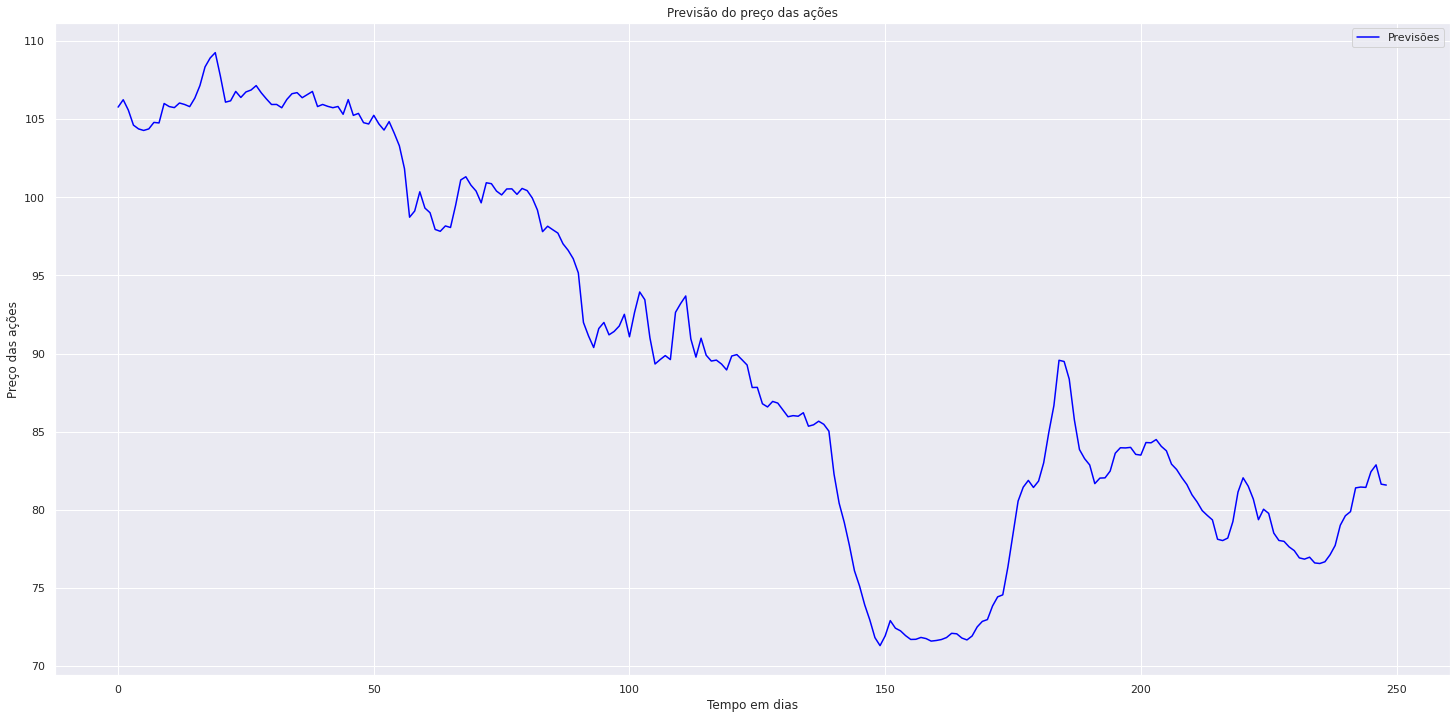

In [88]:
#Visualizando o gráfico da Previsão da rede
#x1 = plt.subplot(2, 1, 1) 
plt.plot(previsoes_sem_base_teste, color = 'blue', label = 'Previsões')
plt.title('Previsão do preço das ações')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço das ações')
plt.legend()
plt.show()

In [92]:
#Dados Estatísticos das previsões
df4 = pd.DataFrame(previsoes_sem_base_teste)
df4.columns = ['Previsoes']
df4.describe()

,Previsoes
count,249.000000
mean,89.875732
std,11.641408
min,71.304726
25%,80.559731
50%,89.267868
75%,100.568825
max,109.262154


In [90]:
#df1 = pd.DataFrame(preco_real_teste)
#df1.describe()

In [91]:
#estatísticas do preço real comparado com a previsão
#df1 = pd.DataFrame(preco_real_teste).T
#df2 = pd.DataFrame(previsoes).T

#df3 = pd.concat([df1,df2]).T
#df3.columns = ['Preco real', 'Previsoes']
#df3.describe()